PyTorch and Image Loading

In [1]:
import numpy as np
import torch

from PIL import Image

In [2]:
path = 'clothing-dataset-small-master/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'

img = Image.open(fullname)

x = img.resize((224, 224)) # Ensure the image has the 224x224 size

X = np.array(x)

X.shape

(224, 224, 3)

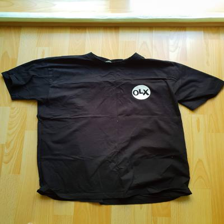

In [3]:
x

Pre-trained Models

In [4]:
import torch

import torchvision.models as models

from PIL import Image
from torchvision import transforms

In [5]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1') # Load a pre-trained model.
model.eval() # Put the model in evaluation mode

# Image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256), # Resizes the image so the shortest side is 256 pixels. Keeps the aspect ratio (doesn't distort).
    transforms.CenterCrop(224), # Takes a centered 224×224 pixel square from the image. MobileNetV2 expects 224×224 images, so this ensures correct size.
    transforms.ToTensor(), # Converts image from PIL format or NumPy array into a PyTorch tensor. Also changes pixel values from range 0–255 to 0–1.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # adjusts pixel values so they match what the model expects.
])

In [6]:
path = 'clothing-dataset-small-master/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'

In [7]:
# Predictions

img = Image.open(fullname) # Opens the image file from your computer. 
                                                                                                # Returns a PIL Image object. 
                                                                                                # Does not convert it to a tensor yet — it’s still a regular image
img_t = preprocess(img) # Preprocess the image as defined before
batch_t = torch.unsqueeze(img_t, 0) # Add a batch dimension. PyTorch models expect batches of images, even if you only have one.

# Run the image through the model (make a prediction)
with torch.no_grad(): # Turns off gradient calculation
    output = model(batch_t) # Passes your image into MobileNetV2. The model returns a tensor of 1000 numbers

# Get top predictions
_, indices = torch.sort(output, descending=True)

In [8]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87Saving 'imagenet_classes.txt'
87imagenet_classes.txt 100% [=============================>]    5.10K    --.-KB/s87HTTP response 200  [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt]
87imagenet_classes.txt 100% [=============================>]    5.10K    --.-KB/s87[Files: 1  Bytes: 5.10K [14.10K]8

In [9]:
indices

tensor([[610, 841, 869, 399, 465, 885, 834, 400, 667, 501, 638, 797, 578, 414,
         906, 842, 824, 750, 614, 588, 697, 636, 570, 796, 608, 457, 474, 546,
         728, 689, 879, 461, 911, 655, 692, 543, 735, 862, 411, 775, 639, 678,
         887, 672, 652, 433, 787, 643, 617, 597, 477, 456, 389, 587, 681, 894,
         793, 711, 459, 568, 827, 596, 490, 515, 422, 524, 830, 808, 549, 589,
         721, 542, 519, 523, 915, 897, 872, 615, 691, 903, 759, 982,   0, 451,
         921, 917, 559, 708, 447, 558, 776, 518, 419, 823, 836, 747, 792, 412,
         764, 752, 819, 601, 566, 513, 600, 594, 620, 852, 771, 585, 713, 658,
         613, 432, 622, 445, 813, 172, 745, 514, 612, 837, 478, 255, 859, 743,
         529, 623, 464, 749, 650, 176, 197, 677, 696, 723, 822, 169, 868, 936,
         741, 811, 439, 763, 740, 802, 854, 402, 686, 790, 699, 898, 395, 200,
         923, 545, 748, 731, 845, 577, 981, 916, 435, 753, 485, 683, 183, 838,
         481, 541, 722, 875, 413, 177, 632, 391, 789

In [10]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jersey
2: sweatshirt
3: trench coat
4: abaya
5: bulletproof vest


Transfer learning

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Build the model

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 1.3057, Train Acc: 0.5857
  Val Loss: 0.8299, Val Acc: 0.7449
Epoch 2/10
  Train Loss: 0.7594, Train Acc: 0.7735
  Val Loss: 0.6634, Val Acc: 0.7801
Epoch 3/10
  Train Loss: 0.6247, Train Acc: 0.8015
  Val Loss: 0.6406, Val Acc: 0.7889
Epoch 4/10
  Train Loss: 0.5460, Train Acc: 0.8321
  Val Loss: 0.5906, Val Acc: 0.8006
Epoch 5/10
  Train Loss: 0.4937, Train Acc: 0.8419
  Val Loss: 0.5740, Val Acc: 0.8035
Epoch 6/10
  Train Loss: 0.4656, Train Acc: 0.8501
  Val Loss: 0.5852, Val Acc: 0.8006
Epoch 7/10
  Train Loss: 0.4386, Train Acc: 0.8527
  Val Loss: 0.5525, Val Acc: 0.8006
Epoch 8/10
  Train Loss: 0.4173, Train Acc: 0.8644
  Val Loss: 0.5539, Val Acc: 0.7918
Epoch 9/10
  Train Loss: 0.3963, Train Acc: 0.8742
  Val Loss: 0.5416, Val Acc: 0.7977
Epoch 10/10
  Train Loss: 0.3685, Train Acc: 0.8823
  Val Loss: 0.5565, Val Acc: 0.8094


Tuning the learning rate

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# Build the model

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()
        
        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

In [8]:
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [9]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs = 10

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 1.9216, Train Acc: 0.3520
  Val Loss: 1.7202, Val Acc: 0.4282
Epoch 2/10
  Train Loss: 1.5910, Train Acc: 0.5101
  Val Loss: 1.4580, Val Acc: 0.5367
Epoch 3/10
  Train Loss: 1.3729, Train Acc: 0.5857
  Val Loss: 1.2761, Val Acc: 0.5953
Epoch 4/10
  Train Loss: 1.2198, Train Acc: 0.6418
  Val Loss: 1.1461, Val Acc: 0.6657
Epoch 5/10
  Train Loss: 1.1070, Train Acc: 0.6943
  Val Loss: 1.0471, Val Acc: 0.6804
Epoch 6/10
  Train Loss: 1.0248, Train Acc: 0.7151
  Val Loss: 0.9782, Val Acc: 0.7097
Epoch 7/10
  Train Loss: 0.9570, Train Acc: 0.7396
  Val Loss: 0.9306, Val Acc: 0.7097
Epoch 8/10
  Train Loss: 0.9075, Train Acc: 0.7480
  Val Loss: 0.8825, Val Acc: 0.7449
Epoch 9/10
  Train Loss: 0.8544, Train Acc: 0.7650
  Val Loss: 0.8464, Val Acc: 0.7654
Epoch 10/10
  Train Loss: 0.8121, Train Acc: 0.7829
  Val Loss: 0.8114, Val Acc: 0.7595

=== Learning Rate: 0.001 ===
Epoch 1/10
  Train Loss: 1.3322, Train Acc: 0.5841
  Val Loss: 0.860

Model Checkpointing

To add to save partial improved validation accuracy models  
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):  
    best_val_accuracy = 0.0 # Initialize variable to track the best validation accuracy  

    Existing code
    
    Checkpoint the model if validation accuracy improved  
    if val_acc > best_val_accuracy:  
        best_val_accuracy = val_acc  
        checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'  
        torch.save(model.state_dict(), checkpoint_path)  
        print(f'Checkpoint saved: {checkpoint_path}')  

Adding inner layers

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze everything
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze last block (features[18] is last inverted residual block)
        for param in self.base_model.features[18].parameters():
            param.requires_grad = True
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()
        
        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [8]:
def make_model(learning_rate=0.001, size_inner=100):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [9]:
learning_rate = 0.001
size_inners = [10, 100, 500, 1000]
num_epochs = 10

for size in size_inners:
    print(f'\n=== Size inner: {size} ===')
    model, optimizer = make_model(learning_rate=learning_rate, size_inner=size)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Size inner: 10 ===
Epoch 1/10
  Train Loss: 1.5323, Train Acc: 0.4967
  Val Loss: 1.0947, Val Acc: 0.5982
Checkpoint saved: mobilenet_v2_01_0.598.pth
Epoch 2/10
  Train Loss: 0.9174, Train Acc: 0.7076
  Val Loss: 0.8229, Val Acc: 0.7243
Checkpoint saved: mobilenet_v2_02_0.724.pth
Epoch 3/10
  Train Loss: 0.6973, Train Acc: 0.7673
  Val Loss: 0.6737, Val Acc: 0.7771
Checkpoint saved: mobilenet_v2_03_0.777.pth
Epoch 4/10
  Train Loss: 0.5884, Train Acc: 0.8090
  Val Loss: 0.6688, Val Acc: 0.7801
Checkpoint saved: mobilenet_v2_04_0.780.pth
Epoch 5/10
  Train Loss: 0.5174, Train Acc: 0.8302
  Val Loss: 0.6915, Val Acc: 0.7625
Epoch 6/10
  Train Loss: 0.4569, Train Acc: 0.8439
  Val Loss: 0.6298, Val Acc: 0.7918
Checkpoint saved: mobilenet_v2_06_0.792.pth
Epoch 7/10
  Train Loss: 0.4172, Train Acc: 0.8667
  Val Loss: 0.6775, Val Acc: 0.7889
Epoch 8/10
  Train Loss: 0.3717, Train Acc: 0.8761
  Val Loss: 0.6773, Val Acc: 0.7859
Epoch 9/10
  Train Loss: 0.3400, Train Acc: 0.8817
  Val Los

Dropout Regularization

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v3_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [8]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [9]:
learning_rate = 0.001
size_inner = 100
droprate = [0.0, 0.2, 0.5, 0.8]
num_epochs = 10

for dr in droprate:
    print(f'\n=== Drop rate: {dr} ===')
    model, optimizer = make_model(learning_rate=learning_rate, size_inner=size_inner, droprate=dr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Drop rate: 0.0 ===
Epoch 1/10
  Train Loss: 1.3947, Train Acc: 0.5567
  Val Loss: 0.8575, Val Acc: 0.7331
Checkpoint saved: mobilenet_v3_01_0.733.pth
Epoch 2/10
  Train Loss: 0.8149, Train Acc: 0.7363
  Val Loss: 0.6502, Val Acc: 0.7830
Checkpoint saved: mobilenet_v3_02_0.783.pth
Epoch 3/10
  Train Loss: 0.6507, Train Acc: 0.7872
  Val Loss: 0.5867, Val Acc: 0.7977
Checkpoint saved: mobilenet_v3_03_0.798.pth
Epoch 4/10
  Train Loss: 0.5867, Train Acc: 0.8008
  Val Loss: 0.7315, Val Acc: 0.7361
Epoch 5/10
  Train Loss: 0.5636, Train Acc: 0.8054
  Val Loss: 0.5953, Val Acc: 0.7918
Epoch 6/10
  Train Loss: 0.4982, Train Acc: 0.8237
  Val Loss: 0.6083, Val Acc: 0.7859
Epoch 7/10
  Train Loss: 0.4698, Train Acc: 0.8351
  Val Loss: 0.6176, Val Acc: 0.7977
Epoch 8/10
  Train Loss: 0.4438, Train Acc: 0.8507
  Val Loss: 0.6108, Val Acc: 0.7918
Epoch 9/10
  Train Loss: 0.4274, Train Acc: 0.8481
  Val Loss: 0.6406, Val Acc: 0.7918
Epoch 10/10
  Train Loss: 0.4216, Train Acc: 0.8507
  Val Los

Improvement suggested by chatGPT

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze last block (features[18] is last inverted residual block)
        for param in self.base_model.features[18].parameters():
            param.requires_grad = True
            
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v3A_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [8]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [9]:
learning_rate = 0.001
size_inner = 100
droprate = [0.2, 0.5]
num_epochs = 10

for dr in droprate:
    print(f'\n=== Drop rate: {dr} ===')
    model, optimizer = make_model(learning_rate=learning_rate, size_inner=size_inner, droprate=dr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Drop rate: 0.2 ===
Epoch 1/10
  Train Loss: 1.0559, Train Acc: 0.6490
  Val Loss: 0.6239, Val Acc: 0.7830
Checkpoint saved: mobilenet_v3A_01_0.783.pth
Epoch 2/10
  Train Loss: 0.6118, Train Acc: 0.7937
  Val Loss: 0.5906, Val Acc: 0.8211
Checkpoint saved: mobilenet_v3A_02_0.821.pth
Epoch 3/10
  Train Loss: 0.5309, Train Acc: 0.8155
  Val Loss: 0.6287, Val Acc: 0.7947
Epoch 4/10
  Train Loss: 0.4475, Train Acc: 0.8409
  Val Loss: 0.5372, Val Acc: 0.8328
Checkpoint saved: mobilenet_v3A_04_0.833.pth
Epoch 5/10
  Train Loss: 0.4060, Train Acc: 0.8582
  Val Loss: 0.5421, Val Acc: 0.8358
Checkpoint saved: mobilenet_v3A_05_0.836.pth
Epoch 6/10
  Train Loss: 0.3641, Train Acc: 0.8784
  Val Loss: 0.5658, Val Acc: 0.8182
Epoch 7/10
  Train Loss: 0.3243, Train Acc: 0.8889
  Val Loss: 0.5893, Val Acc: 0.8328
Epoch 8/10
  Train Loss: 0.3069, Train Acc: 0.8898
  Val Loss: 0.5944, Val Acc: 0.8094
Epoch 9/10
  Train Loss: 0.2685, Train Acc: 0.9032
  Val Loss: 0.6558, Val Acc: 0.8270
Epoch 10/10
 

Data Augmentation

In [1]:
# import numpy as np
import os
import torch

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Simple preprocessing

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
# Create dataloaders

train_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='clothing-dataset-small-master/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze last block (features[18] is last inverted residual block)
        for param in self.base_model.features[18].parameters():
            param.requires_grad = True
            
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [6]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [8]:
def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.5
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [9]:
learning_rate = 0.001
size_inner = 100
droprate = 0.5
num_epochs = 50

print(f'\n=== Leaning rate: {learning_rate}, size_inner: {size_inner}, droprate: {droprate} ===')
model, optimizer = make_model(learning_rate=learning_rate, size_inner=size_inner, droprate=droprate)
train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Leaning rate: 0.001, size_inner: 100, droprate: 0.5 ===
Epoch 1/50
  Train Loss: 1.2754, Train Acc: 0.5694
  Val Loss: 0.6645, Val Acc: 0.7859
Checkpoint saved: mobilenet_v4_01_0.786.pth
Epoch 2/50
  Train Loss: 0.7880, Train Acc: 0.7370
  Val Loss: 0.5749, Val Acc: 0.8182
Checkpoint saved: mobilenet_v4_02_0.818.pth
Epoch 3/50
  Train Loss: 0.6255, Train Acc: 0.7973
  Val Loss: 0.5515, Val Acc: 0.8240
Checkpoint saved: mobilenet_v4_03_0.824.pth
Epoch 4/50
  Train Loss: 0.5621, Train Acc: 0.8103
  Val Loss: 0.5565, Val Acc: 0.8328
Checkpoint saved: mobilenet_v4_04_0.833.pth
Epoch 5/50
  Train Loss: 0.5448, Train Acc: 0.8217
  Val Loss: 0.5751, Val Acc: 0.8328
Epoch 6/50
  Train Loss: 0.5292, Train Acc: 0.8201
  Val Loss: 0.5340, Val Acc: 0.8358
Checkpoint saved: mobilenet_v4_06_0.836.pth
Epoch 7/50
  Train Loss: 0.4624, Train Acc: 0.8462
  Val Loss: 0.5857, Val Acc: 0.8182
Epoch 8/50
  Train Loss: 0.4392, Train Acc: 0.8452
  Val Loss: 0.5754, Val Acc: 0.8299
Epoch 9/50
  Train Loss

Using the Trained Model

In [1]:
# import numpy as np
import glob
import re
import torch

import torch.nn as nn

import torchvision.models as models

In [2]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze last block (features[18] is last inverted residual block)
        for param in self.base_model.features[18].parameters():
            param.requires_grad = True
            
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [3]:
def extract_accuracy(filename):
    """
    Extracts the accuracy value from filenames like:
    mobilenet_v3A_06_0.845.pth
    """
    match = re.search(r"_([0-9]*\.[0-9]+)\.pth$", filename)
    if match:
        return float(match.group(1))
    return -1  # If something goes wrong

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Find best checkpoint
list_of_files = glob.glob('mobilenet_v*.pth')
best_model_file = [x for x in list_of_files if str(max([extract_accuracy(x) for x in list_of_files])) in x][0]
print(f"Loading model from: {best_model_file}")

# Architecture used during training
trained_size_inner = 100      # ← change to whatever you trained with
trained_droprate   = 0.5      # ← same as training
num_classes        = 10

# Load model
model = ClothingClassifierMobileNet(
    size_inner=trained_size_inner, 
    droprate=trained_droprate, 
    num_classes=num_classes
)

model.load_state_dict(torch.load(best_model_file))
model.to(device)
model.eval();

Loading model from: mobilenet_v4_09_0.853.pth


Making Predictions

In [6]:
from keras_image_helper import create_preprocessor
import numpy as np

def preprocess_pytorch_style(X):
    # X: shape (1, 224, 224, 3), dtype=float32, values in [0, 255]
    X = X / 255.0
    
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    
    # Convert NHWC → NCHW (batch, height, width, channels → batch, channels, height, width)
    X = X.transpose(0, 3, 1, 2)
    
    # Normalize
    X = (X - mean) / std
    
    return X.astype(np.float32)

preprocessor = create_preprocessor(preprocess_pytorch_style, target_size=(224, 224))

# Predict from URL
url = 'http://bit.ly/mlbookcamp-pants'
X = preprocessor.from_url(url)
X = torch.Tensor(X).to(device)

with torch.no_grad():
    pred = model(X).cpu().numpy()[0]

classes = [
    "dress", "hat", "longsleeve", "outwear", "pants",
    "shirt", "shoes", "shorts", "skirt", "t-shirt"
]

result = dict(zip(classes, pred.tolist()))
sorted_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
print(sorted_result)

{'pants': 9.957886695861816, 'shirt': 1.0419607162475586, 'longsleeve': 0.877927303314209, 'shorts': 0.5323584079742432, 'outwear': 0.45997199416160583, 'dress': 0.14334730803966522, 'skirt': -3.8915657997131348, 't-shirt': -5.16563081741333, 'shoes': -10.506382942199707, 'hat': -13.092768669128418}


Exporting to ONNX

In [7]:
# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v4.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_path}")

/tmp/ipykernel_83977/1660462527.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ClothingClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 104 of general pattern rewrite rules.
Model exported to clothing_classifier_mobilenet_v4.onnx
